<h1>Méthode suivie</h1>

Comme détaillé dans le rapport joint (livrable 1), nous allons suivre des traitements en cascade sur les planches de jeu "Où est Charlie ?" afin d'être en mesure de résoudre le jeu. 

<h3>Etape 1 : Réduction de l’espace de recherche par filtrage colorim´ etrique</h3>

Dans cette étape, nous allons réduire l'espace de recherche à l'aide d'un filtrage colorimétrique, en tirant profit de la signature visuelle forte de notre cible : Charlie (rayures rouges et blanches notamment). Nous allons commencer par convertir notre planche dans l'espace HSV pour séparer l'information chromatique de l'intensité lumineuse. Nous nettoierons ensuite le bruit de sorte à n'obtenir à l'issue de cette première étape qu'un masque bianire traduisant les ROI (Regions Of Interest).

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

planche_path = "./original-images/"
planche_file = planche_path + "19.jpg"

In [26]:
def pretraitement_planche(image_path, marge_mask=10):
    image = cv2.imread(image_path)
    if image is None:
        print("Erreur : Image introuvable.")
        return None, None, None
        
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_red1 = np.array([0, 70, 50])
    upper_red1 = np.array([10, 255, 255])
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)

    lower_red2 = np.array([170, 70, 50])
    upper_red2 = np.array([179, 255, 255])
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)

    mask_red = cv2.bitwise_or(mask1, mask2)
    kernel_ouverture = np.ones((3, 3), np.uint8)
    mask_base = cv2.morphologyEx(mask_red, cv2.MORPH_OPEN, kernel_ouverture)
    
    kernel_fermeture_vert = np.ones((15, 5), np.uint8) 
    mask_base = cv2.morphologyEx(mask_base, cv2.MORPH_CLOSE, kernel_fermeture_vert, iterations=2)

    contours, _ = cv2.findContours(mask_base, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    rois = []
    image_resultat = image.copy() 

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        rois.append((x, y, w, h))
        cv2.rectangle(image_resultat, (x, y), (x+w, y+h), (0, 255, 0), 2)

    taille_noyau = (2 * marge_mask) + 1
    kernel_mask = np.ones((taille_noyau, taille_noyau), np.uint8)
    
    mask_final = cv2.dilate(mask_base, kernel_mask, iterations=1)

    return rois, mask_final, image_resultat

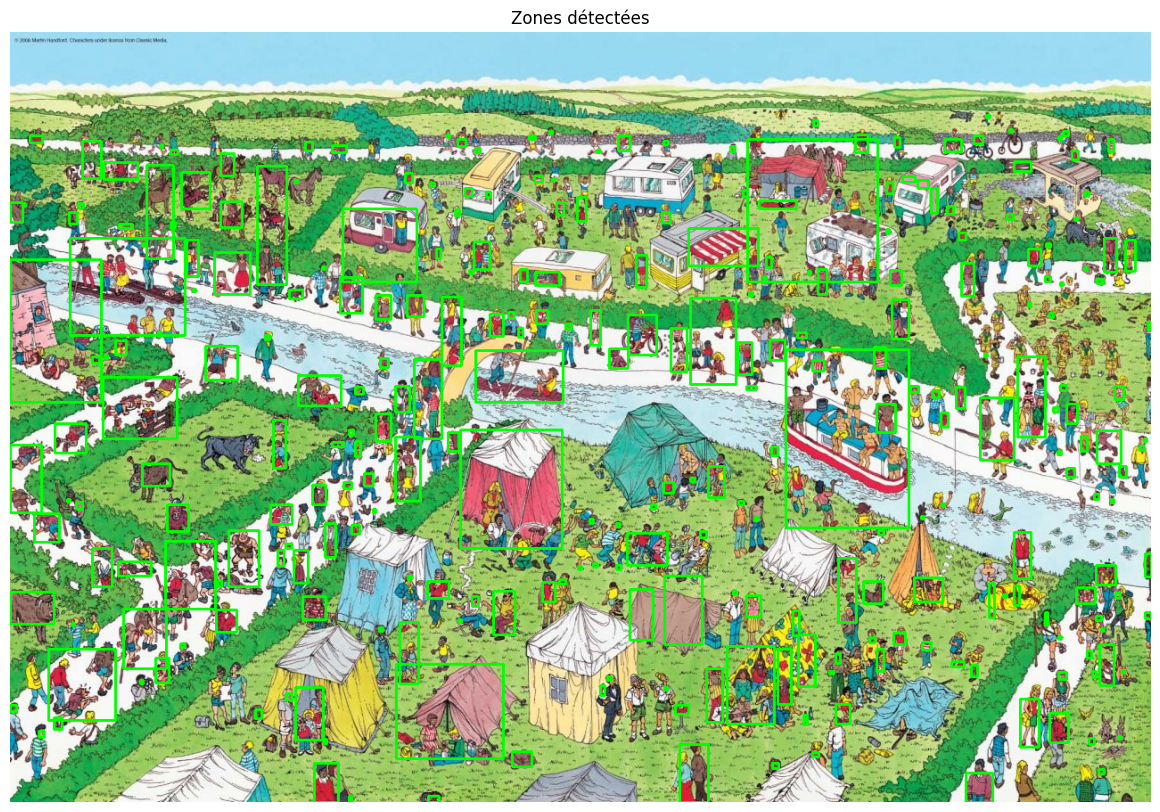

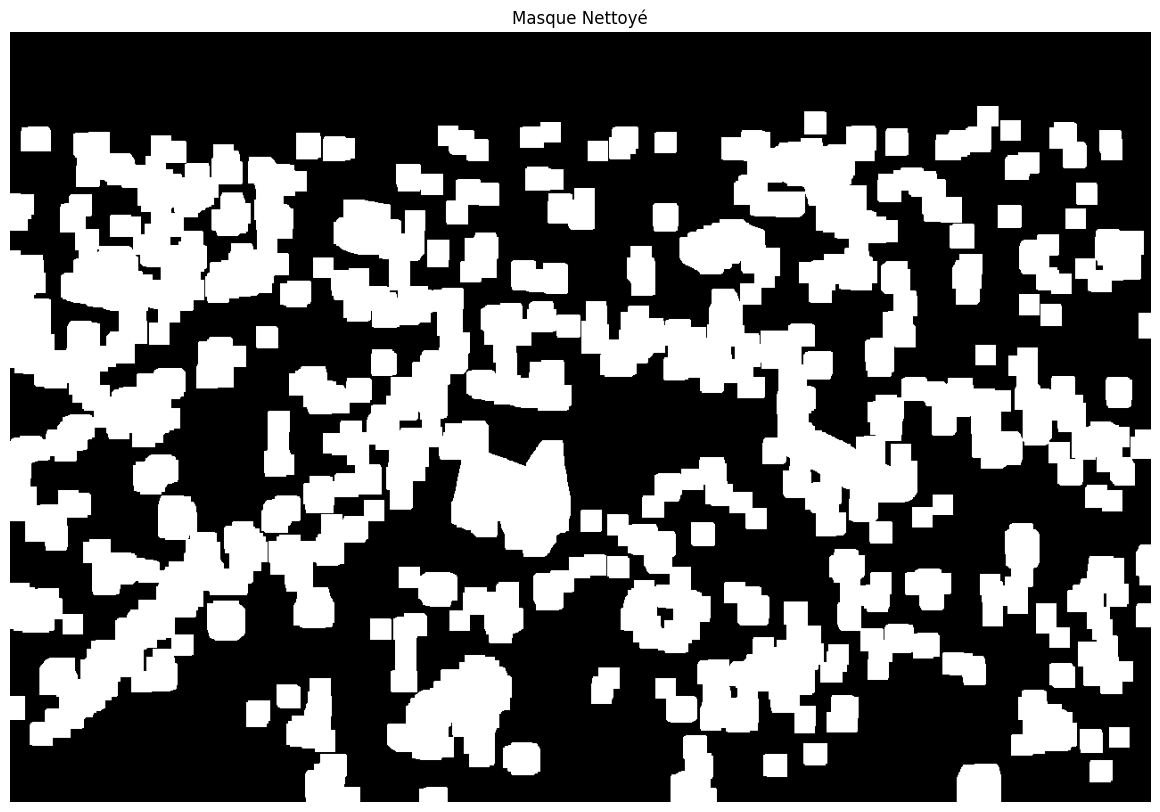

In [27]:
rois, mask, img_bbox = pretraitement_planche(planche_file)
img_rgb = cv2.cvtColor(img_bbox, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 10))
plt.imshow(img_rgb)
plt.title("Zones détectées")
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 10))
plt.imshow(mask, cmap='gray')
plt.title("Masque Nettoyé")
plt.axis('off')
plt.show()

<h3>Etape 2 : Extraction de primitives locales</h3>

Sur les zones d'intérêt indentifiées à l'étape 1, nous allons maintenant appliquer l'algorithme SIFT pour obtenir les keypoints et leus descripteurs associés, afin de pouvoir comparer à notre base de référence d'images de Charlie, qui entrera en jeu dans l'étape suivante.

In [28]:
def extraire_sift_rois(image_bgr, rois):
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()

    sift_data = {}

    img_visualisation = image_bgr.copy()

    for (x, y, w, h) in rois:
        roi_gray = gray[y:y+h, x:x+w]
        keypoints, descriptors = sift.detectAndCompute(roi_gray, None)

        if descriptors is not None and len(keypoints) > 0:
            sift_data[(x, y, w, h)] = {'keypoints': keypoints, 'descriptors': descriptors}
            for kp in keypoints:
                kp.pt = (kp.pt[0] + x, kp.pt[1] + y)
            img_visualisation = cv2.drawKeypoints(img_visualisation, keypoints, img_visualisation, 
                                                  flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return sift_data, img_visualisation

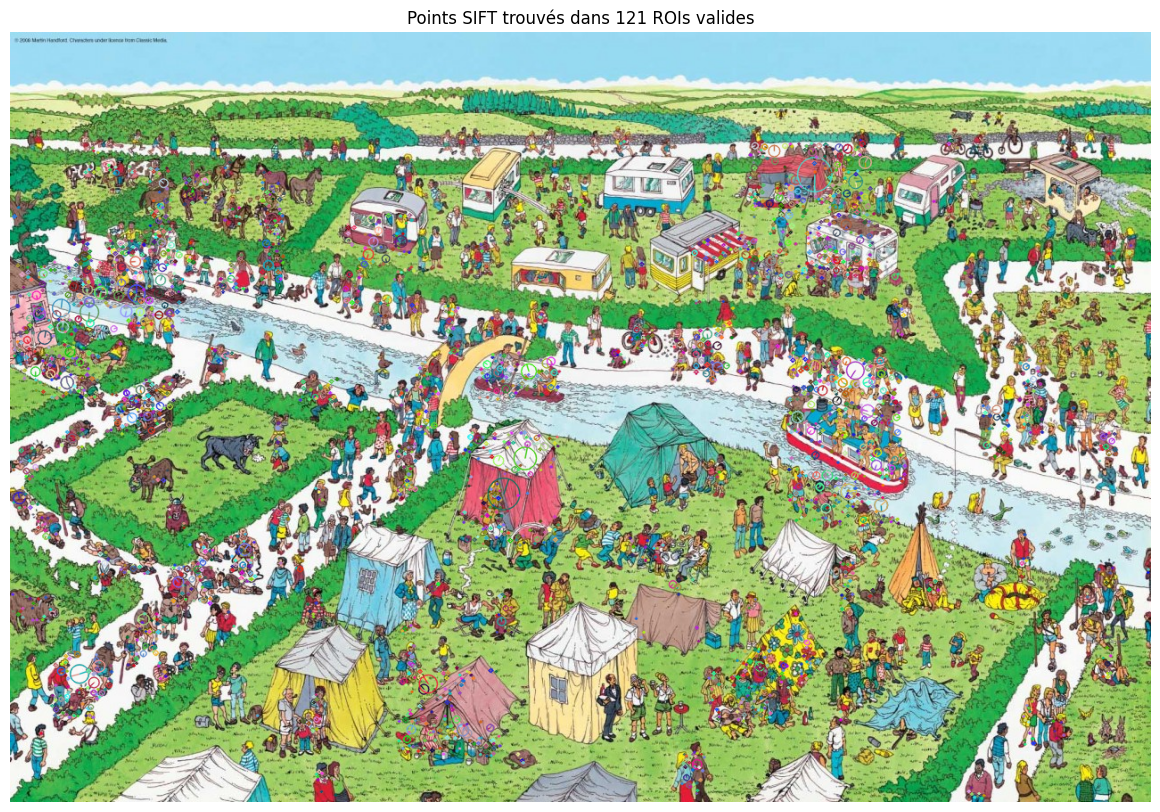

La première ROI possède une matrice de descripteurs de forme : (11, 128)


In [29]:
sift_data, img_sift = extraire_sift_rois(cv2.imread(planche_file), rois)

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_sift, cv2.COLOR_BGR2RGB))
plt.title(f"Points SIFT trouvés dans {len(sift_data)} ROIs valides")
plt.axis('off')
plt.show()


premiere_roi = list(sift_data.keys())[0]
descripteurs = sift_data[premiere_roi]['descriptors']
print(f"La première ROI possède une matrice de descripteurs de forme : {descripteurs.shape}") 